## Import Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
from itertools import chain

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import transform_fns as trans
import pdm_functions as fns
from sklearn.metrics import precision_score, recall_score, f1_score
import process_fns as pfns
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split


## csv file to tensor 

In [2]:
print("Current working directory:", os.getcwd())

Current working directory: C:\SK\ai_proj\data_analysis


In [3]:
# def PostProcessing(file_name, cols=['spectrum_x_amp', 'spectrum_y_amp', 'spectrum_z_amp']):
#     """  Index=True 로 저장된 csv 파일을 전처리하여 stack 된 tensor 반환

#     file_name : 파일 경로
#     cols : 컬럼 리스트, 기본값) ['spectrum_x_amp', 'spectrum_y_amp', 'spectrum_z_amp']
#     """
#     # csv 파일 로드
#     df = pd.read_csv(file_name, header=[0], index_col=[0, 1])
    
#     # 각 행의 리스트를 병합, 첫번째 데이터는 버림
#     for col in cols:
#         df[col] = df[col].apply(lambda x: [float(j) for j in x.split(',')][1:])
    
#     # 각 컬럼의 데이터를 병합
#     new_df = df[cols].apply(lambda x: list(chain.from_iterable(x)), axis=1)

#     # 그룹별로 데이터를 모아서 텐서로 변환하고 스택
#     tensors = [torch.tensor(item) for item in new_df.groupby(level=0).apply(lambda x: [item for sublist in x for item in sublist])]
    
#     # 텐서들을 스택
#     result = torch.stack(tensors)

#     return result


In [4]:
df_normal_for_weight= pd.read_csv('dataset/5528_spec_normal.csv')
# df_error= pd.read_csv('dataset/5528_spec_error.csv')

### Generating Weighted Function for Imbalance 

In [5]:
df_normal_for_weight['spectrum_x_amp']= df_normal_for_weight['spectrum_x_amp'].apply(lambda x: [float(num) for num in x.split(',')][1:])
# type(df_normal_for_weight['spectrum_x_amp'][0])
df_normal_for_weight['spectrum_x_amp'][0][-2:]

[0.0005112148024065443, 0.000526803676930039]

In [6]:
len(df_normal_for_weight['spectrum_x_amp'][0]), type(df_normal_for_weight['spectrum_x_amp'])

(2048, pandas.core.series.Series)

In [7]:
print(df_normal_for_weight['spectrum_x_amp'].dtype)

object


In [8]:
df_normal_for_weight

,date,cnt,created_at,spectrum_x_amp,spectrum_y_amp,spectrum_z_amp
0,2024-01-12,0,1704901985,"[0.0006416402772945482, 0.0006967116032034175,...","0.00020635396946099019,0.0003100558571815329,0...","0.0002770334279662072,0.0004462952954874889,0...."
1,2024-01-12,1,1704909194,"[0.00046743998424794654, 0.0002757226016452911...","0.00016051611590231604,0.0001113571030668683,0...","0.00029144869690031743,0.0003112218193772041,0..."
2,2024-01-12,2,1704916397,"[0.00028399929256615647, 0.0003624820057698942...","9.14235290461346e-05,0.00010227322932295558,7....","0.00018883640812350743,0.0003188173517410369,0..."
3,2024-01-12,3,1704923605,"[6.886010749249397e-05, 0.00015660348397942753...","0.00015404194614079104,0.0002930843035366268,0...","0.00039784871799657633,0.0005350226945562514,0..."
4,2024-01-12,4,1704930808,"[0.0013137867109838262, 0.002479297796449496, ...","0.0012457594683349597,0.002439545756240494,0.0...","0.0007305390559110608,0.0005454625258034126,0...."
...,...,...,...,...,...,...
2143,2024-08-26,7,1724568616,"[0.00019601150211220783, 0.0002110699028518240...","1.1633523187097993e-05,9.156793209300532e-05,8...","0.00033064314160995134,0.0002569970897037031,5..."
2144,2024-08-26,8,1724575824,"[0.00013065276184553336, 8.733154273262023e-05...","3.745356993574565e-05,0.00010148446522604481,0...","0.00012312103946281763,0.00016672132401543419,..."
2145,2024-08-26,9,1724583026,"[0.00011971222976955133, 0.0003781453419813549...","0.0001284091193688998,0.00029905809843392436,0...","1.7062427571507954e-05,0.00030063687937896983,..."
2146,2024-08-26,10,1724590235,"[0.00015052913262383972, 0.0001496677730241791...","2.1079643827683487e-05,0.0001310912999130868,0...","0.00020875115418941018,0.0002161621726146461,0..."


In [9]:
def rpm_approx_weighted_fn(df_spectrum, x_val_min, x_val_max, num_linspace): 
    """ approximating rpm from dominant amplitude on frequency domain
    parameters:
    df_spectrum(pands Series) 

    return:
    """
    df_max_index = pd.Series(df_spectrum.apply(lambda x: x.index(max(x)) if max(x) >= 0.02 else 0))
    df_max_index = df_max_index[df_max_index != 0]
    kde = gaussian_kde(df_max_index)
    kde_values = kde(np.linspace(x_val_min, x_val_max, num_linspace)) 
    kde_values_list = kde_values.tolist()

    return kde_values_list

In [10]:
wf = rpm_approx_weighted_fn(df_normal_for_weight['spectrum_x_amp'], 1 , 2048, 2048)
# sns.lineplot(wf)
# wf.index(max(wf))
# kde_val = rpm_approx_weighted_fn(df_normal_for_weight['spectrum_x_amp'], 1, 2048, 2048)

<Axes: >

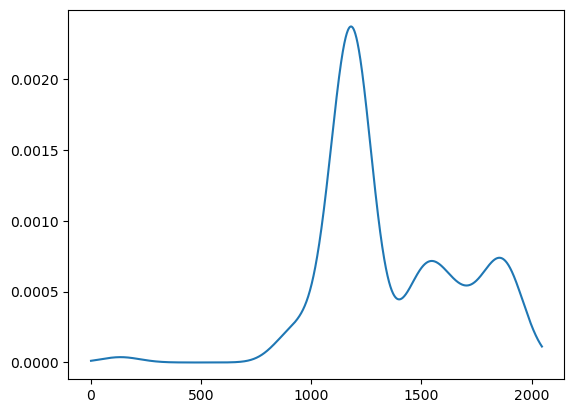

In [11]:
sns.lineplot(wf) 

### <span style='color:red'> This maxval is going to be one of hyperparameters </span>

In [12]:
# wf = fns.min_max_standardization(wf, maxval = 4)
# sns.lineplot(wf)

In [13]:
wf = wf * 36

<Axes: >

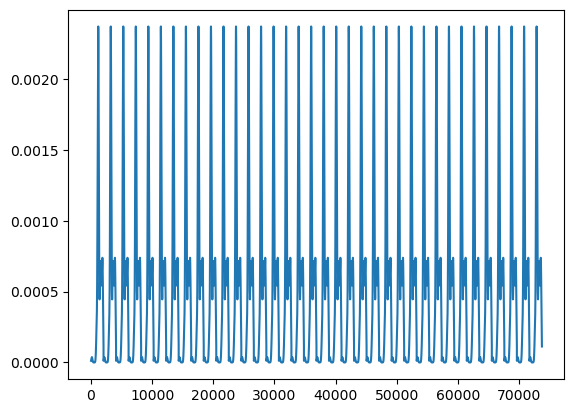

In [14]:
sns.lineplot(wf)

In [15]:
# len(wf)

In [16]:
wf = torch.tensor(wf)
wf

tensor([1.1912e-05, 1.2119e-05, 1.2329e-05,  ..., 1.1739e-04, 1.1502e-04,
        1.1269e-04])

### Generating Bogus Datasets

In [17]:
# df_normal = fns.csv_to_tensor_stack('dataset/5528_spec_normal.csv')
# df_error = fns.csv_to_tensor_stack('dataset/5528_spec_error.csv')

In [18]:
# df_normal.shape, df_error.shape

In [19]:
# df_normal = fns.multi_datasets(df_normal, multi_dim = 50)
# df_error = fns.multi_datasets(df_error, multi_dim = 600)

In [20]:
# df_normal.shape, df_error.shape

In [21]:
# sns.lineplot(df_normal[10])

### Weighted Function * Datasets

In [22]:
# df_normal = df_normal * wf
# df_error = df_error * wf

In [23]:
# sns.lineplot(df_normal[10])

In [24]:
# spec_freq = [0.78125,1.5625,2.34375,3.125,3.90625,4.6875,5.46875,6.25,7.03125,7.8125,8.59375,9.375,10.15625,10.9375,11.71875,12.5,13.28125,14.0625,14.84375,15.625,16.40625,17.1875,17.96875,18.75,19.53125,20.3125,21.09375,21.875,22.65625,23.4375,24.21875,25,25.78125,26.5625,27.34375,28.125,28.90625,29.6875,30.46875,31.25,32.03125,32.8125,33.59375,34.375,35.15625,35.9375,36.71875,37.5,38.28125,39.0625,39.84375,40.625,41.40625,42.1875,42.96875,43.75,44.53125,45.3125,46.09375,46.875,47.65625,48.4375,49.21875,50,50.78125,51.5625,52.34375,53.125,53.90625,54.6875,55.46875,56.25,57.03125,57.8125,58.59375,59.375,60.15625,60.9375,61.71875,62.5,63.28125,64.0625,64.84375,65.625,66.40625,67.1875,67.96875,68.75,69.53125,70.3125,71.09375,71.875,72.65625,73.4375,74.21875,75,75.78125,76.5625,77.34375,78.125,78.90625,79.6875,80.46875,81.25,82.03125,82.8125,83.59375,84.375,85.15625,85.9375,86.71875,87.5,88.28125,89.0625,89.84375,90.625,91.40625,92.1875,92.96875,93.75,94.53125,95.3125,96.09375,96.875,97.65625,98.4375,99.21875,100,100.78125,101.5625,102.34375,103.125,103.90625,104.6875,105.46875,106.25,107.03125,107.8125,108.59375,109.375,110.15625,110.9375,111.71875,112.5,113.28125,114.0625,114.84375,115.625,116.40625,117.1875,117.96875,118.75,119.53125,120.3125,121.09375,121.875,122.65625,123.4375,124.21875,125,125.78125,126.5625,127.34375,128.125,128.90625,129.6875,130.46875,131.25,132.03125,132.8125,133.59375,134.375,135.15625,135.9375,136.71875,137.5,138.28125,139.0625,139.84375,140.625,141.40625,142.1875,142.96875,143.75,144.53125,145.3125,146.09375,146.875,147.65625,148.4375,149.21875,150,150.78125,151.5625,152.34375,153.125,153.90625,154.6875,155.46875,156.25,157.03125,157.8125,158.59375,159.375,160.15625,160.9375,161.71875,162.5,163.28125,164.0625,164.84375,165.625,166.40625,167.1875,167.96875,168.75,169.53125,170.3125,171.09375,171.875,172.65625,173.4375,174.21875,175,175.78125,176.5625,177.34375,178.125,178.90625,179.6875,180.46875,181.25,182.03125,182.8125,183.59375,184.375,185.15625,185.9375,186.71875,187.5,188.28125,189.0625,189.84375,190.625,191.40625,192.1875,192.96875,193.75,194.53125,195.3125,196.09375,196.875,197.65625,198.4375,199.21875,200,200.78125,201.5625,202.34375,203.125,203.90625,204.6875,205.46875,206.25,207.03125,207.8125,208.59375,209.375,210.15625,210.9375,211.71875,212.5,213.28125,214.0625,214.84375,215.625,216.40625,217.1875,217.96875,218.75,219.53125,220.3125,221.09375,221.875,222.65625,223.4375,224.21875,225,225.78125,226.5625,227.34375,228.125,228.90625,229.6875,230.46875,231.25,232.03125,232.8125,233.59375,234.375,235.15625,235.9375,236.71875,237.5,238.28125,239.0625,239.84375,240.625,241.40625,242.1875,242.96875,243.75,244.53125,245.3125,246.09375,246.875,247.65625,248.4375,249.21875,250,250.78125,251.5625,252.34375,253.125,253.90625,254.6875,255.46875,256.25,257.03125,257.8125,258.59375,259.375,260.15625,260.9375,261.71875,262.5,263.28125,264.0625,264.84375,265.625,266.40625,267.1875,267.96875,268.75,269.53125,270.3125,271.09375,271.875,272.65625,273.4375,274.21875,275,275.78125,276.5625,277.34375,278.125,278.90625,279.6875,280.46875,281.25,282.03125,282.8125,283.59375,284.375,285.15625,285.9375,286.71875,287.5,288.28125,289.0625,289.84375,290.625,291.40625,292.1875,292.96875,293.75,294.53125,295.3125,296.09375,296.875,297.65625,298.4375,299.21875,300,300.78125,301.5625,302.34375,303.125,303.90625,304.6875,305.46875,306.25,307.03125,307.8125,308.59375,309.375,310.15625,310.9375,311.71875,312.5,313.28125,314.0625,314.84375,315.625,316.40625,317.1875,317.96875,318.75,319.53125,320.3125,321.09375,321.875,322.65625,323.4375,324.21875,325,325.78125,326.5625,327.34375,328.125,328.90625,329.6875,330.46875,331.25,332.03125,332.8125,333.59375,334.375,335.15625,335.9375,336.71875,337.5,338.28125,339.0625,339.84375,340.625,341.40625,342.1875,342.96875,343.75,344.53125,345.3125,346.09375,346.875,347.65625,348.4375,349.21875,350,350.78125,351.5625,352.34375,353.125,353.90625,354.6875,355.46875,356.25,357.03125,357.8125,358.59375,359.375,360.15625,360.9375,361.71875,362.5,363.28125,364.0625,364.84375,365.625,366.40625,367.1875,367.96875,368.75,369.53125,370.3125,371.09375,371.875,372.65625,373.4375,374.21875,375,375.78125,376.5625,377.34375,378.125,378.90625,379.6875,380.46875,381.25,382.03125,382.8125,383.59375,384.375,385.15625,385.9375,386.71875,387.5,388.28125,389.0625,389.84375,390.625,391.40625,392.1875,392.96875,393.75,394.53125,395.3125,396.09375,396.875,397.65625,398.4375,399.21875,400,400.78125,401.5625,402.34375,403.125,403.90625,404.6875,405.46875,406.25,407.03125,407.8125,408.59375,409.375,410.15625,410.9375,411.71875,412.5,413.28125,414.0625,414.84375,415.625,416.40625,417.1875,417.96875,418.75,419.53125,420.3125,421.09375,421.875,422.65625,423.4375,424.21875,425,425.78125,426.5625,427.34375,428.125,428.90625,429.6875,430.46875,431.25,432.03125,432.8125,433.59375,434.375,435.15625,435.9375,436.71875,437.5,438.28125,439.0625,439.84375,440.625,441.40625,442.1875,442.96875,443.75,444.53125,445.3125,446.09375,446.875,447.65625,448.4375,449.21875,450,450.78125,451.5625,452.34375,453.125,453.90625,454.6875,455.46875,456.25,457.03125,457.8125,458.59375,459.375,460.15625,460.9375,461.71875,462.5,463.28125,464.0625,464.84375,465.625,466.40625,467.1875,467.96875,468.75,469.53125,470.3125,471.09375,471.875,472.65625,473.4375,474.21875,475,475.78125,476.5625,477.34375,478.125,478.90625,479.6875,480.46875,481.25,482.03125,482.8125,483.59375,484.375,485.15625,485.9375,486.71875,487.5,488.28125,489.0625,489.84375,490.625,491.40625,492.1875,492.96875,493.75,494.53125,495.3125,496.09375,496.875,497.65625,498.4375,499.21875,500,500.78125,501.5625,502.34375,503.125,503.90625,504.6875,505.46875,506.25,507.03125,507.8125,508.59375,509.375,510.15625,510.9375,511.71875,512.5,513.28125,514.0625,514.84375,515.625,516.40625,517.1875,517.96875,518.75,519.53125,520.3125,521.09375,521.875,522.65625,523.4375,524.21875,525,525.78125,526.5625,527.34375,528.125,528.90625,529.6875,530.46875,531.25,532.03125,532.8125,533.59375,534.375,535.15625,535.9375,536.71875,537.5,538.28125,539.0625,539.84375,540.625,541.40625,542.1875,542.96875,543.75,544.53125,545.3125,546.09375,546.875,547.65625,548.4375,549.21875,550,550.78125,551.5625,552.34375,553.125,553.90625,554.6875,555.46875,556.25,557.03125,557.8125,558.59375,559.375,560.15625,560.9375,561.71875,562.5,563.28125,564.0625,564.84375,565.625,566.40625,567.1875,567.96875,568.75,569.53125,570.3125,571.09375,571.875,572.65625,573.4375,574.21875,575,575.78125,576.5625,577.34375,578.125,578.90625,579.6875,580.46875,581.25,582.03125,582.8125,583.59375,584.375,585.15625,585.9375,586.71875,587.5,588.28125,589.0625,589.84375,590.625,591.40625,592.1875,592.96875,593.75,594.53125,595.3125,596.09375,596.875,597.65625,598.4375,599.21875,600,600.78125,601.5625,602.34375,603.125,603.90625,604.6875,605.46875,606.25,607.03125,607.8125,608.59375,609.375,610.15625,610.9375,611.71875,612.5,613.28125,614.0625,614.84375,615.625,616.40625,617.1875,617.96875,618.75,619.53125,620.3125,621.09375,621.875,622.65625,623.4375,624.21875,625,625.78125,626.5625,627.34375,628.125,628.90625,629.6875,630.46875,631.25,632.03125,632.8125,633.59375,634.375,635.15625,635.9375,636.71875,637.5,638.28125,639.0625,639.84375,640.625,641.40625,642.1875,642.96875,643.75,644.53125,645.3125,646.09375,646.875,647.65625,648.4375,649.21875,650,650.78125,651.5625,652.34375,653.125,653.90625,654.6875,655.46875,656.25,657.03125,657.8125,658.59375,659.375,660.15625,660.9375,661.71875,662.5,663.28125,664.0625,664.84375,665.625,666.40625,667.1875,667.96875,668.75,669.53125,670.3125,671.09375,671.875,672.65625,673.4375,674.21875,675,675.78125,676.5625,677.34375,678.125,678.90625,679.6875,680.46875,681.25,682.03125,682.8125,683.59375,684.375,685.15625,685.9375,686.71875,687.5,688.28125,689.0625,689.84375,690.625,691.40625,692.1875,692.96875,693.75,694.53125,695.3125,696.09375,696.875,697.65625,698.4375,699.21875,700,700.78125,701.5625,702.34375,703.125,703.90625,704.6875,705.46875,706.25,707.03125,707.8125,708.59375,709.375,710.15625,710.9375,711.71875,712.5,713.28125,714.0625,714.84375,715.625,716.40625,717.1875,717.96875,718.75,719.53125,720.3125,721.09375,721.875,722.65625,723.4375,724.21875,725,725.78125,726.5625,727.34375,728.125,728.90625,729.6875,730.46875,731.25,732.03125,732.8125,733.59375,734.375,735.15625,735.9375,736.71875,737.5,738.28125,739.0625,739.84375,740.625,741.40625,742.1875,742.96875,743.75,744.53125,745.3125,746.09375,746.875,747.65625,748.4375,749.21875,750,750.78125,751.5625,752.34375,753.125,753.90625,754.6875,755.46875,756.25,757.03125,757.8125,758.59375,759.375,760.15625,760.9375,761.71875,762.5,763.28125,764.0625,764.84375,765.625,766.40625,767.1875,767.96875,768.75,769.53125,770.3125,771.09375,771.875,772.65625,773.4375,774.21875,775,775.78125,776.5625,777.34375,778.125,778.90625,779.6875,780.46875,781.25,782.03125,782.8125,783.59375,784.375,785.15625,785.9375,786.71875,787.5,788.28125,789.0625,789.84375,790.625,791.40625,792.1875,792.96875,793.75,794.53125,795.3125,796.09375,796.875,797.65625,798.4375,799.21875,800,800.78125,801.5625,802.34375,803.125,803.90625,804.6875,805.46875,806.25,807.03125,807.8125,808.59375,809.375,810.15625,810.9375,811.71875,812.5,813.28125,814.0625,814.84375,815.625,816.40625,817.1875,817.96875,818.75,819.53125,820.3125,821.09375,821.875,822.65625,823.4375,824.21875,825,825.78125,826.5625,827.34375,828.125,828.90625,829.6875,830.46875,831.25,832.03125,832.8125,833.59375,834.375,835.15625,835.9375,836.71875,837.5,838.28125,839.0625,839.84375,840.625,841.40625,842.1875,842.96875,843.75,844.53125,845.3125,846.09375,846.875,847.65625,848.4375,849.21875,850,850.78125,851.5625,852.34375,853.125,853.90625,854.6875,855.46875,856.25,857.03125,857.8125,858.59375,859.375,860.15625,860.9375,861.71875,862.5,863.28125,864.0625,864.84375,865.625,866.40625,867.1875,867.96875,868.75,869.53125,870.3125,871.09375,871.875,872.65625,873.4375,874.21875,875,875.78125,876.5625,877.34375,878.125,878.90625,879.6875,880.46875,881.25,882.03125,882.8125,883.59375,884.375,885.15625,885.9375,886.71875,887.5,888.28125,889.0625,889.84375,890.625,891.40625,892.1875,892.96875,893.75,894.53125,895.3125,896.09375,896.875,897.65625,898.4375,899.21875,900,900.78125,901.5625,902.34375,903.125,903.90625,904.6875,905.46875,906.25,907.03125,907.8125,908.59375,909.375,910.15625,910.9375,911.71875,912.5,913.28125,914.0625,914.84375,915.625,916.40625,917.1875,917.96875,918.75,919.53125,920.3125,921.09375,921.875,922.65625,923.4375,924.21875,925,925.78125,926.5625,927.34375,928.125,928.90625,929.6875,930.46875,931.25,932.03125,932.8125,933.59375,934.375,935.15625,935.9375,936.71875,937.5,938.28125,939.0625,939.84375,940.625,941.40625,942.1875,942.96875,943.75,944.53125,945.3125,946.09375,946.875,947.65625,948.4375,949.21875,950,950.78125,951.5625,952.34375,953.125,953.90625,954.6875,955.46875,956.25,957.03125,957.8125,958.59375,959.375,960.15625,960.9375,961.71875,962.5,963.28125,964.0625,964.84375,965.625,966.40625,967.1875,967.96875,968.75,969.53125,970.3125,971.09375,971.875,972.65625,973.4375,974.21875,975,975.78125,976.5625,977.34375,978.125,978.90625,979.6875,980.46875,981.25,982.03125,982.8125,983.59375,984.375,985.15625,985.9375,986.71875,987.5,988.28125,989.0625,989.84375,990.625,991.40625,992.1875,992.96875,993.75,994.53125,995.3125,996.09375,996.875,997.65625,998.4375,999.21875,1000,1000.78125,1001.5625,1002.34375,1003.125,1003.90625,1004.6875,1005.46875,1006.25,1007.03125,1007.8125,1008.59375,1009.375,1010.15625,1010.9375,1011.71875,1012.5,1013.28125,1014.0625,1014.84375,1015.625,1016.40625,1017.1875,1017.96875,1018.75,1019.53125,1020.3125,1021.09375,1021.875,1022.65625,1023.4375,1024.21875,1025,1025.78125,1026.5625,1027.34375,1028.125,1028.90625,1029.6875,1030.46875,1031.25,1032.03125,1032.8125,1033.59375,1034.375,1035.15625,1035.9375,1036.71875,1037.5,1038.28125,1039.0625,1039.84375,1040.625,1041.40625,1042.1875,1042.96875,1043.75,1044.53125,1045.3125,1046.09375,1046.875,1047.65625,1048.4375,1049.21875,1050,1050.78125,1051.5625,1052.34375,1053.125,1053.90625,1054.6875,1055.46875,1056.25,1057.03125,1057.8125,1058.59375,1059.375,1060.15625,1060.9375,1061.71875,1062.5,1063.28125,1064.0625,1064.84375,1065.625,1066.40625,1067.1875,1067.96875,1068.75,1069.53125,1070.3125,1071.09375,1071.875,1072.65625,1073.4375,1074.21875,1075,1075.78125,1076.5625,1077.34375,1078.125,1078.90625,1079.6875,1080.46875,1081.25,1082.03125,1082.8125,1083.59375,1084.375,1085.15625,1085.9375,1086.71875,1087.5,1088.28125,1089.0625,1089.84375,1090.625,1091.40625,1092.1875,1092.96875,1093.75,1094.53125,1095.3125,1096.09375,1096.875,1097.65625,1098.4375,1099.21875,1100,1100.78125,1101.5625,1102.34375,1103.125,1103.90625,1104.6875,1105.46875,1106.25,1107.03125,1107.8125,1108.59375,1109.375,1110.15625,1110.9375,1111.71875,1112.5,1113.28125,1114.0625,1114.84375,1115.625,1116.40625,1117.1875,1117.96875,1118.75,1119.53125,1120.3125,1121.09375,1121.875,1122.65625,1123.4375,1124.21875,1125,1125.78125,1126.5625,1127.34375,1128.125,1128.90625,1129.6875,1130.46875,1131.25,1132.03125,1132.8125,1133.59375,1134.375,1135.15625,1135.9375,1136.71875,1137.5,1138.28125,1139.0625,1139.84375,1140.625,1141.40625,1142.1875,1142.96875,1143.75,1144.53125,1145.3125,1146.09375,1146.875,1147.65625,1148.4375,1149.21875,1150,1150.78125,1151.5625,1152.34375,1153.125,1153.90625,1154.6875,1155.46875,1156.25,1157.03125,1157.8125,1158.59375,1159.375,1160.15625,1160.9375,1161.71875,1162.5,1163.28125,1164.0625,1164.84375,1165.625,1166.40625,1167.1875,1167.96875,1168.75,1169.53125,1170.3125,1171.09375,1171.875,1172.65625,1173.4375,1174.21875,1175,1175.78125,1176.5625,1177.34375,1178.125,1178.90625,1179.6875,1180.46875,1181.25,1182.03125,1182.8125,1183.59375,1184.375,1185.15625,1185.9375,1186.71875,1187.5,1188.28125,1189.0625,1189.84375,1190.625,1191.40625,1192.1875,1192.96875,1193.75,1194.53125,1195.3125,1196.09375,1196.875,1197.65625,1198.4375,1199.21875,1200,1200.78125,1201.5625,1202.34375,1203.125,1203.90625,1204.6875,1205.46875,1206.25,1207.03125,1207.8125,1208.59375,1209.375,1210.15625,1210.9375,1211.71875,1212.5,1213.28125,1214.0625,1214.84375,1215.625,1216.40625,1217.1875,1217.96875,1218.75,1219.53125,1220.3125,1221.09375,1221.875,1222.65625,1223.4375,1224.21875,1225,1225.78125,1226.5625,1227.34375,1228.125,1228.90625,1229.6875,1230.46875,1231.25,1232.03125,1232.8125,1233.59375,1234.375,1235.15625,1235.9375,1236.71875,1237.5,1238.28125,1239.0625,1239.84375,1240.625,1241.40625,1242.1875,1242.96875,1243.75,1244.53125,1245.3125,1246.09375,1246.875,1247.65625,1248.4375,1249.21875,1250,1250.78125,1251.5625,1252.34375,1253.125,1253.90625,1254.6875,1255.46875,1256.25,1257.03125,1257.8125,1258.59375,1259.375,1260.15625,1260.9375,1261.71875,1262.5,1263.28125,1264.0625,1264.84375,1265.625,1266.40625,1267.1875,1267.96875,1268.75,1269.53125,1270.3125,1271.09375,1271.875,1272.65625,1273.4375,1274.21875,1275,1275.78125,1276.5625,1277.34375,1278.125,1278.90625,1279.6875,1280.46875,1281.25,1282.03125,1282.8125,1283.59375,1284.375,1285.15625,1285.9375,1286.71875,1287.5,1288.28125,1289.0625,1289.84375,1290.625,1291.40625,1292.1875,1292.96875,1293.75,1294.53125,1295.3125,1296.09375,1296.875,1297.65625,1298.4375,1299.21875,1300,1300.78125,1301.5625,1302.34375,1303.125,1303.90625,1304.6875,1305.46875,1306.25,1307.03125,1307.8125,1308.59375,1309.375,1310.15625,1310.9375,1311.71875,1312.5,1313.28125,1314.0625,1314.84375,1315.625,1316.40625,1317.1875,1317.96875,1318.75,1319.53125,1320.3125,1321.09375,1321.875,1322.65625,1323.4375,1324.21875,1325,1325.78125,1326.5625,1327.34375,1328.125,1328.90625,1329.6875,1330.46875,1331.25,1332.03125,1332.8125,1333.59375,1334.375,1335.15625,1335.9375,1336.71875,1337.5,1338.28125,1339.0625,1339.84375,1340.625,1341.40625,1342.1875,1342.96875,1343.75,1344.53125,1345.3125,1346.09375,1346.875,1347.65625,1348.4375,1349.21875,1350,1350.78125,1351.5625,1352.34375,1353.125,1353.90625,1354.6875,1355.46875,1356.25,1357.03125,1357.8125,1358.59375,1359.375,1360.15625,1360.9375,1361.71875,1362.5,1363.28125,1364.0625,1364.84375,1365.625,1366.40625,1367.1875,1367.96875,1368.75,1369.53125,1370.3125,1371.09375,1371.875,1372.65625,1373.4375,1374.21875,1375,1375.78125,1376.5625,1377.34375,1378.125,1378.90625,1379.6875,1380.46875,1381.25,1382.03125,1382.8125,1383.59375,1384.375,1385.15625,1385.9375,1386.71875,1387.5,1388.28125,1389.0625,1389.84375,1390.625,1391.40625,1392.1875,1392.96875,1393.75,1394.53125,1395.3125,1396.09375,1396.875,1397.65625,1398.4375,1399.21875,1400,1400.78125,1401.5625,1402.34375,1403.125,1403.90625,1404.6875,1405.46875,1406.25,1407.03125,1407.8125,1408.59375,1409.375,1410.15625,1410.9375,1411.71875,1412.5,1413.28125,1414.0625,1414.84375,1415.625,1416.40625,1417.1875,1417.96875,1418.75,1419.53125,1420.3125,1421.09375,1421.875,1422.65625,1423.4375,1424.21875,1425,1425.78125,1426.5625,1427.34375,1428.125,1428.90625,1429.6875,1430.46875,1431.25,1432.03125,1432.8125,1433.59375,1434.375,1435.15625,1435.9375,1436.71875,1437.5,1438.28125,1439.0625,1439.84375,1440.625,1441.40625,1442.1875,1442.96875,1443.75,1444.53125,1445.3125,1446.09375,1446.875,1447.65625,1448.4375,1449.21875,1450,1450.78125,1451.5625,1452.34375,1453.125,1453.90625,1454.6875,1455.46875,1456.25,1457.03125,1457.8125,1458.59375,1459.375,1460.15625,1460.9375,1461.71875,1462.5,1463.28125,1464.0625,1464.84375,1465.625,1466.40625,1467.1875,1467.96875,1468.75,1469.53125,1470.3125,1471.09375,1471.875,1472.65625,1473.4375,1474.21875,1475,1475.78125,1476.5625,1477.34375,1478.125,1478.90625,1479.6875,1480.46875,1481.25,1482.03125,1482.8125,1483.59375,1484.375,1485.15625,1485.9375,1486.71875,1487.5,1488.28125,1489.0625,1489.84375,1490.625,1491.40625,1492.1875,1492.96875,1493.75,1494.53125,1495.3125,1496.09375,1496.875,1497.65625,1498.4375,1499.21875,1500,1500.78125,1501.5625,1502.34375,1503.125,1503.90625,1504.6875,1505.46875,1506.25,1507.03125,1507.8125,1508.59375,1509.375,1510.15625,1510.9375,1511.71875,1512.5,1513.28125,1514.0625,1514.84375,1515.625,1516.40625,1517.1875,1517.96875,1518.75,1519.53125,1520.3125,1521.09375,1521.875,1522.65625,1523.4375,1524.21875,1525,1525.78125,1526.5625,1527.34375,1528.125,1528.90625,1529.6875,1530.46875,1531.25,1532.03125,1532.8125,1533.59375,1534.375,1535.15625,1535.9375,1536.71875,1537.5,1538.28125,1539.0625,1539.84375,1540.625,1541.40625,1542.1875,1542.96875,1543.75,1544.53125,1545.3125,1546.09375,1546.875,1547.65625,1548.4375,1549.21875,1550,1550.78125,1551.5625,1552.34375,1553.125,1553.90625,1554.6875,1555.46875,1556.25,1557.03125,1557.8125,1558.59375,1559.375,1560.15625,1560.9375,1561.71875,1562.5,1563.28125,1564.0625,1564.84375,1565.625,1566.40625,1567.1875,1567.96875,1568.75,1569.53125,1570.3125,1571.09375,1571.875,1572.65625,1573.4375,1574.21875,1575,1575.78125,1576.5625,1577.34375,1578.125,1578.90625,1579.6875,1580.46875,1581.25,1582.03125,1582.8125,1583.59375,1584.375,1585.15625,1585.9375,1586.71875,1587.5,1588.28125,1589.0625,1589.84375,1590.625,1591.40625,1592.1875,1592.96875,1593.75,1594.53125,1595.3125,1596.09375,1596.875,1597.65625,1598.4375,1599.21875,1600]
# spec_freq = torch.tensor(spec_freq)
# print(spec_freq.shape)


In [25]:

# import transform_fns as trans
# standardized_freq = trans.standardized(spec_freq, 2)
# weighted_arr = trans.weighted_function(standardized_freq, .2)
# expanded_arr = weighted_arr.repeat(36)

# result = df_normal * expanded_arr

# x = x * expanded_arr

# result = model(df_normal, spec_freq)
# result_error = model(df_error, spec_freq)

In [26]:
# def process_data(spec_freq, df_normal, maxval, rate, repeat_times=36):
#     """
#     Process the spectral frequency data.

#     Parameters:
#         spec_freq (torch.Tensor): The input spectral frequency tensor.
#         df_normal (torch.Tensor): The normal DataFrame tensor.
#         maxval (float): The maximum value for standardization.
#         rate (float): The rate for the weighted function.
#         repeat_times (int): Number of times to repeat the weighted array.

#     Returns:
#         torch.Tensor: The processed result after applying the operations.
#     """
#     # Standardize the frequency
#     standardized_freq = trans.standardized(spec_freq, maxval)

#     # Apply the weighted function
#     weighted_arr = trans.weighted_function(standardized_freq, rate)

#     # Expand the array
#     expanded_arr = weighted_arr.repeat(repeat_times)

#     # Perform element-wise multiplication
#     result = df_normal * expanded_arr

#     return result


In [27]:
# result = process_data(spec_freq, df_normal, 2, .2, repeat_times=36)
# result.shape

In [28]:
# fig, axes = plt.subplots(nrows=12, ncols=2, figsize=(15,30)) 

# for i in range(12):
#     ylim = torch.max(df_normal[i].max(), result[i].max())

#     axes[i, 0].plot(df_normal[i])
#     axes[i, 0].set_title('Original')
#     axes[i, 0].set_ylim(0, ylim)
    
#     axes[i, 1].plot(result[i])
#     axes[i, 1].set_title('After model')
#     axes[i, 1].set_ylim(0, ylim)

# plt.tight_layout()  
# plt.savefig('one_day_weighted_normal.png', dpi=300) 
# plt.show()

In [29]:
# fig, axes = plt.subplots(nrows=12, ncols=2, figsize=(15,30)) 

# for i in range(12):
#     ylim = torch.max(df_error[i].max(), result[i].max())

#     axes[i, 0].plot(df_error[i])
#     axes[i, 0].set_title('Original')
#     axes[i, 0].set_ylim(0, ylim)
    
#     axes[i, 1].plot(result_error[i])
#     axes[i, 1].set_title('After model')
#     axes[i, 1].set_ylim(0, ylim)

# plt.tight_layout()  
# plt.savefig('one_day_weighted_error.png', dpi=300) 
# plt.show()

## Top x from 73000

In [30]:
# def get_sorted_top_k_values(tensor, k=5000):
#     """
#     Extract the top k values from each row of a 2D tensor
#     and sort them based on their original indices.
    
#     Args:
#         tensor (torch.Tensor): Input tensor of shape (num_rows, num_columns).
#         k (int): The number of top values to extract from each row.
        
#     Returns:
#         torch.Tensor: A tensor of shape (num_rows, k) containing the sorted top k values.
#     """
#     top_values, top_indices = torch.topk(tensor, k, sorted=False)

#     # Sort the top values according to the indices
#     sorted_indices = torch.argsort(top_indices, dim=1)
#     sorted_top_values = torch.gather(top_values, 1, sorted_indices)
    
#     return sorted_top_values

In [31]:
# top_10000, top_10000_indices = torch.topk(result, 10000, sorted=False)
# top_5000_values, top_5000_indices = torch.topk(result, 5000, sorted=False)
# top_5000_values.shape, top_5000_indices.shape

In [32]:
# result.shape

In [33]:
# result_5000 = get_sorted_top_k_values(result)

In [34]:
# sns.lineplot(result_5000[10])

In [35]:
# fig, axes = plt.subplots(nrows=12, figsize=(8,30)) 

# for i in range(12):
#     # ylim = torch.max(df_normal[i].max(), result[i].max())
#     val, ind = torch.topk(result[i], 5000, sorted=False)
#     intacted_5000 = val[torch.argsort(ind)]
#     axes[i].plot(intacted_5000)
#     axes[i].set_title(f'First 5000 largest values {i}')
#     # axes[i, 1].set_ylim(0, ylim)

# plt.tight_layout()  
# plt.savefig('top_5000.png', dpi=300) 
# plt.show()

In [36]:
# top_5000_normal= fns.get_sorted_top_k_values(df_normal)
# top_5000_error = fns.get_sorted_top_k_values(df_error)
# print(top_5000_normal.shape); print(top_5000_error.shape)

In [37]:
# sns.lineplot(top_5000_normal[10])

## Dataset Ready

In [38]:
datasets = pfns.PostProcessing('dataset/5528_droped_data.csv')

C:\SK\ai_proj\data_analysis\process_fns.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: [float(j) for j in x][1:])
C:\SK\ai_proj\data_analysis\process_fns.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: [float(j) for j in x][1:])
C:\SK\ai_proj\data_analysis\process_fns.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [77]:
train_sets = datasets[0]
dev_sets = datasets[1]
test_sets= datasets[2]


In [78]:
train_sets[0]
print(len(train_sets[0]), len(dev_sets[0]), len(test_sets[0]))

121 37 37


In [79]:
train_set_aug = fns.multi_datasets(train_sets[0], multi_dim= 10)

In [80]:
train_set_aug.shape

torch.Size([1210, 73728])

In [81]:
# train_label_aug = np.repeat(train_sets[1], 10, axis= 0)
# train_label_aug.shape
train_sets[1] = train_sets[1].reshape((121,1))
train_label = np.repeat(train_sets[1], 10, axis= 0) 


In [82]:
train_label.shape

torch.Size([1210, 1])

In [83]:
train_label_aug = train_label

In [84]:
# from create_dataset import LabelingData


In [85]:
# train_x, test_x, train_label, test_label = fns.binary_labeling(top_5000_normal, top_5000_error, .2, random_state=42) 

In [86]:
# train_x.shape, test_x.shape, train_label.shape, test_label.shape

In [87]:
# sns.lineplot(train_x[1])

<Axes: >

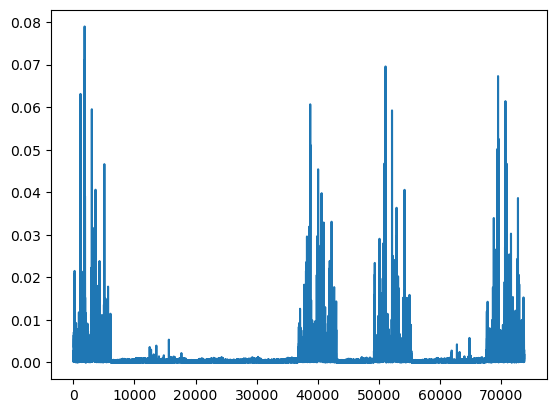

In [88]:
sns.lineplot(train_set_aug[0])

In [89]:
train_set_aug_sh, _, train_label_aug_sh, _ = train_test_split(train_set_aug, train_label_aug, test_size=1) 

In [90]:
train_set_aug_sh.shape, train_set_aug.shape

(torch.Size([1209, 73728]), torch.Size([1210, 73728]))

In [91]:
train_label_aug_sh.shape, train_label_aug.shape

(torch.Size([1209, 1]), torch.Size([1210, 1]))

<Axes: >

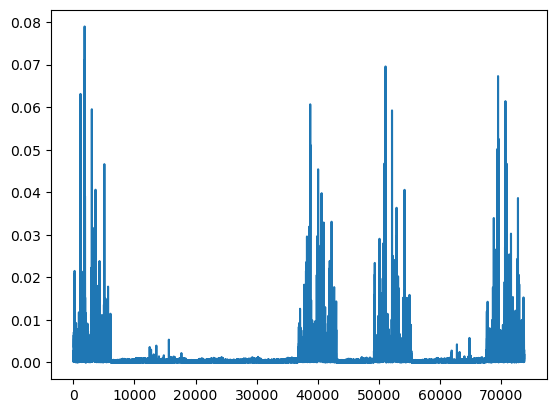

In [92]:
train_set_aug_sh = train_set_aug_sh * wf
sns.lineplot(train_set_aug[0])

### <span style="color:red"> This (* 1000) is going to be one of hyperparameters  </span>

In [93]:
# train_x = trans.get_sorted_top_k_values(train_x) * 10
train_x = trans.get_sorted_top_k_values(train_set_aug_sh) * 100000

<Axes: >

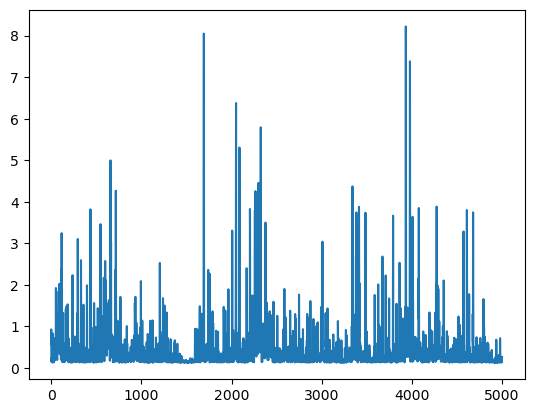

In [94]:
sns.lineplot(train_x[0])

In [95]:
train_x.shape
train_label_aug = train_label_aug.squeeze()
print(train_label_aug.shape)

torch.Size([1210])


In [96]:
test_x.shape, test_label.shape

NameError: name 'test_x' is not defined

In [ ]:
train_x.shape , train_label_aug.shape

In [97]:
# train_dataset = TensorDataset(train_x, train_label)
train_dataset = TensorDataset(train_x, train_label_aug)

AssertionError: Size mismatch between tensors

In [98]:
test_dataset = TensorDataset(test_x, test_label)

NameError: name 'test_x' is not defined

In [99]:
train_dataset.tensors

NameError: name 'train_dataset' is not defined

In [100]:
test_dataset.tensors

NameError: name 'test_dataset' is not defined

In [101]:
dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

NameError: name 'train_dataset' is not defined

In [102]:
dataloader_test =DataLoader(test_dataset, batch_size=64, shuffle=True)

NameError: name 'test_dataset' is not defined

In [71]:
dataloader

NameError: name 'dataloader' is not defined

In [72]:
# for x_batch, labels in dataloader:
#     print(x_batch.shape, labels.shape)

In [73]:
# for x_batch, labels in dataloader_test:
#     print(x_batch.shape, labels.shape)

## Model Structure

In [74]:
learning_rate = 0.001
num_epochs = 10

model = nn.Sequential(
         nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),  
    nn.ReLU(), 
    nn.MaxPool1d(kernel_size=2),  
    nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),  
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(32 * (5000 // 4), 64), 
    nn.ReLU(),
    nn.Linear(64, 2)  
        )


criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [75]:
print(model)

Sequential(
  (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (1): ReLU()
  (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (4): ReLU()
  (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=40000, out_features=64, bias=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=2, bias=True)
)


### Model Training

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for x_batch, labels in dataloader:

        x_batch = x_batch.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        # Reshape x_batch to have one input channel
        x_batch = x_batch.unsqueeze(1)  # Shape: (batch_size, 1, 5000)
        
        outputs = model(x_batch)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

cuda


NameError: name 'dataloader' is not defined

## Model Evaluation

In [ ]:
model.eval()

# Initialize variables to keep track of the loss and predictions
total_loss = 0.0
all_labels = []
all_predictions = []

with torch.no_grad():
    for x_batch, labels in dataloader_test:  

        x_batch = x_batch.to(device)
        labels = labels.to(device)
        
        x_batch = x_batch.unsqueeze(1)  # Shape: (batch_size, 1, 5000)
        
        outputs = model(x_batch)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        
        total_loss += loss.item()  # Accumulate the loss
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        
        all_labels.extend(labels.cpu().numpy())  # Store true labels
        all_predictions.extend(predicted.cpu().numpy())  # Store predicted labels

# Calculate average loss
avg_loss = total_loss / len(dataloader)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')  # Use 'micro' or 'macro' if needed
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Print results
print(f"Evaluation Loss: {avg_loss:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

## Test Model
